<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to build a Multi-Modal ranking system.

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Dataset: [Google Review](https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_restaurants)
Steps:
1. Download train dataset for Google Local Restraunts

2. Build Multi-Modal Index/Vector Store for Restraunts

3. Retrieve top k texts and imaged matched Restraunts

4. Simple reranking Restraunts based on image and text retrieval score

5. Select top scoring Restraunt for GPT4V to label relevant

6. Repeat steps 3-5 to collection more labled data for different search queries

7. Train a learning to rank model using GPT4V score as label

8. Inference learning to rank model on test set



In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

## Read the google review raw json data including text, image, rating, gmap_id (uuid for a restraunt)

In [ ]:
import json
from pathlib import Path
import requests
import urllib.request
from collections import defaultdict
from llama_index.readers import JSONReader
from llama_index.schema import ImageDocument, Document

# reader = JSONReader(multi_lines = True)
# data = reader.load_data('./review-Hawaii_small.json')
json_file = "./review-Hawaii_small.json"
text_documents = []
img_documents = []
num_doc = 0
MAX_DOCS = 300
image_uuid = 0
gmap_id_cnt = defaultdict(lambda: 0)

data_path = Path("google_review_data")
if not data_path.exists():
    Path.mkdir(data_path)

with open(json_file, encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        # data = reader.load_data(line)
        # break
        # print(data)
        if "text" not in data or not data["text"]:
            continue
        metadata = {}
        image_urls = []
        metadata["rating"] = data["rating"]
        metadata["gmap_id"] = data["gmap_id"]

        if "pics" in data and data["pics"]:
            for pic in data["pics"]:
                image_urls.append(pic["url"][0])
            # image_url = data['pics'][0]['url']
            # print(image_url)
        # image_url = data['image']
        if image_urls:
            metadata["image_url"] = image_urls[0]
            try:
                urllib.request.urlretrieve(
                    metadata["image_url"], data_path / f"{image_uuid}.jpg"
                )
                image_path = str(data_path / f"{image_uuid}.jpg")
                print(image_path)
                image_uuid += 1
                gmap_id_cnt[metadata["gmap_id"]] += 1
                if gmap_id_cnt[metadata["gmap_id"]] >= 5:
                    continue
            except:
                print("Google Review Image download Error")
                continue

        if "image_url" in metadata and metadata["image_url"]:
            text_documents.append(
                Document(text=data["text"], metadata=metadata)
            )

            img_documents.append(
                ImageDocument(image_path=image_path, metadata=metadata)
            )

        if len(text_documents) >= MAX_DOCS:
            break

# print(len(text_documents))
# print(len(img_documents))

## Count how many unique stores in our dateset

In [ ]:
gmap_id_set = set()
for doc in text_documents:
    # print(doc.image_path)
    # print(doc.metadata['gmap_id'])
    gmap_id_set.add(doc.metadata["gmap_id"])
print(len(gmap_id_set))

143


In [ ]:
import os

OPENAI_API_TOKEN = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Build Multi-Modal Index for iamges and texts for Google restraunts

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.indices.vector_store import VectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_new_db_9")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
# documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
# index = MultiModalVectorStoreIndex.from_documents(
index = MultiModalVectorStoreIndex.from_documents(
    text_documents + img_documents,
    storage_context=storage_context,
    image_vector_store=image_store,
)

/Users/haotianzhang/llama_index/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## Retrieve top matched restraunts for a query based on images and text

In [ ]:
from llama_index.vector_stores.types import ExactMatchFilter, MetadataFilters
from llama_index.response.notebook_utils import (
    display_source_node,
    display_image_uris,
)
from llama_index.schema import ImageNode


# filters = MetadataFilters(
#     filters=[ExactMatchFilter(key="rating", value=5)]
# )
search_query = "sandwich"
retriever = index.as_retriever(similarity_top_k=20, image_similarity_top_k=20)
response = retriever.retrieve(search_query)
retrieved_images = []

for res_node in response:
    if isinstance(res_node.node, ImageNode):
        retrieved_images.append(res_node.node.image_path)
    else:
        display_source_node(res_node, source_length=200)
    print(res_node.node.metadata["gmap_id"], res_node.score)

**Node ID:** 300b0e3d-da57-4cf5-8998-f3b5440beb18<br>**Similarity:** 0.8250716417611288<br>**Text:** Delicious banh mi sandwiches!! I loved and appreciated how packed full they were of meat and pickled carrots, cucumbers, and daikon. All for $6.95 for a reasonable size! A clean dining area and nic...<br>

0x7c008bdd7ebfe161:0xe04d5de101a266ae 0.8250716417611288


**Node ID:** 07eeb76c-f532-49b0-8a5d-eaf065570325<br>**Similarity:** 0.8208614473896383<br>**Text:** Very convenient location for sandwiches and smoothies and juices. Food was good, of course a little pricey due to location.<br>

0x7c007278edb2a865:0x4ed1c3d61fda94aa 0.8208614473896383


**Node ID:** 5cfe9b64-380f-48ab-ae40-f8bb787af143<br>**Similarity:** 0.8166808144288462<br>**Text:** Most convenient spot to Queen’s beach with simple, hot and tasty panini sandwiches, and yes it is pricey but it’s expected for the area and real estate. Currently the corner Starbucks is closed so ...<br>

0x7c007278edb2a865:0x4ed1c3d61fda94aa 0.8166808144288462


**Node ID:** 5a7010e0-d184-4f62-aac6-8424ec6638d5<br>**Similarity:** 0.8159435415926457<br>**Text:** Clean and nice lunch<br>

0x7954d2c20cb7ec5f:0x125d0dfdf7fd7b30 0.8159435415926457


**Node ID:** e049d1dd-18ea-4718-b1ad-162bf32aa93d<br>**Similarity:** 0.8004855980977617<br>**Text:** Lemongrass chicken was superb! I normally hate cilantro but surprisingly it was tolerable and loved it on the bahn mi! I also had to ruin the sandwich with Sriracha lol credit, debit and cash are a...<br>

0x7c008bdd7ebfe161:0xe04d5de101a266ae 0.8004855980977617


**Node ID:** b8ff4e3e-e232-42f7-bc18-db62cd2bad13<br>**Similarity:** 0.8003223137531607<br>**Text:** You could miss it if you blink, but that’s what I love about this spot: quiet and not tourist ridden. Prices are fair (especially for Maui) and portions are extremely generous- less than $15 gets y...<br>

0x7954d376a8b12db3:0xa51dd57e1cc14ca9 0.8003223137531607


**Node ID:** 985dbec5-be93-4549-9d3b-275508243ea7<br>**Similarity:** 0.8003223137531607<br>**Text:** You could miss it if you blink, but that’s what I love about this spot: quiet and not tourist ridden. Prices are fair (especially for Maui) and portions are extremely generous- less than $15 gets y...<br>

0x7954d376a8b12db3:0xa51dd57e1cc14ca9 0.8003223137531607


**Node ID:** a6e0beed-8767-4cdf-905c-e1df8ff16c93<br>**Similarity:** 0.796768063799382<br>**Text:** This place was fun and tasty for a light snack.<br>

0x7eaad4c65352eddf:0xe88cc994f4822e63 0.796768063799382


**Node ID:** 5372855a-5c6f-47e0-8490-0f3393b8481f<br>**Similarity:** 0.796768063799382<br>**Text:** This place was fun and tasty for a light snack.<br>

0x7eaad4c65352eddf:0xe88cc994f4822e63 0.796768063799382


**Node ID:** 92ecdd58-39f6-4a37-aeee-46a4de9d2bcf<br>**Similarity:** 0.7937583357297203<br>**Text:** Great vibe with patio sitting next to ocean. The drink and mahi mahi sandwich were both refreshing and filling after a day at the beach. A big shout out to Shana, she was friendly and attentive. Ow...<br>

0x7c06e132e123e925:0xbc09611c3bf0b3c3 0.7937583357297203


**Node ID:** a7af1438-9704-4342-a3ad-31dd9c78e140<br>**Similarity:** 0.7929208865356309<br>**Text:** Huge menu. Great place for a quick meal.<br>

0x7954d03f1651832b:0xfc465817c5bb7bc7 0.7929208865356309


**Node ID:** de86b856-9b31-4f35-982b-8492b4aa3d9a<br>**Similarity:** 0.7918249440511616<br>**Text:** Quick service, busy little cafe, beef, chicken, rice, salad, beverages.<br>

0x7954d332107caa35:0xc630efdfc08cc59 0.7918249440511616


**Node ID:** bc4726b8-b015-429e-b216-55901d489a48<br>**Similarity:** 0.7886452234185228<br>**Text:** Good, warm musubis! Granted, I've never had musubis before but these are decent for the price! The longanisa was really good/tasty. Would get it again if I was in a hurry and needed a snack for a h...<br>

0x7c00137bbb534d6f:0x46b43968fa377bc0 0.7886452234185228


**Node ID:** 6903ed7d-136d-493f-a255-07fc4c492b1c<br>**Similarity:** 0.7850321597602321<br>**Text:** We stopped by this stand on our trip to Hana to grab a loaf of banana bread. Guy, the owner, was so kind to us and thanked us for coming multiple times. We got some fresh banana bread and an avocad...<br>

0x7954ad0f41bb63df:0x9a0a5f3ccab74bc6 0.7850321597602321


**Node ID:** d3d89184-c0f3-43c3-9516-011dcd808b4e<br>**Similarity:** 0.7839628446179662<br>**Text:** Great place for a quick bite. Good food, friendly staff and great smoothies.<br>

0x7c007278edb2a865:0x4ed1c3d61fda94aa 0.7839628446179662


**Node ID:** 786f41c0-f2c3-46e2-9c60-d9da68b5524b<br>**Similarity:** 0.7836171356276459<br>**Text:** Superb!  Coolest dude runs this place, and the mango bread was OUTSTANDING 👌  Put a huge smile on our faces after visiting the nearby black sand beach at Waiʻānapanapa State Park<br>

0x7954ad0f41bb63df:0x9a0a5f3ccab74bc6 0.7836171356276459


**Node ID:** cb142d85-28d7-4dcf-9941-b76477b81a0a<br>**Similarity:** 0.7827427950058526<br>**Text:** Beautiful outlook. Two picnic tables with a shelter over them.<br>

0x7c06e1349cf54817:0xd5e5a2e4ebcb4083 0.7827427950058526


**Node ID:** e1d7b87d-f522-4848-b7f9-decb619e193f<br>**Similarity:** 0.7821760191921479<br>**Text:** It's in a mall food court which was a little surprising, but has a definite Hawaii flair. Lots to choose from including some basic food court offerings (hamburger and fries). I tried the chicken an...<br>

0x7954d2c20cb7ec5f:0x125d0dfdf7fd7b30 0.7821760191921479


**Node ID:** 1b4ee203-0034-4a78-a1ce-122645f353de<br>**Similarity:** 0.780652453689182<br>**Text:** Amazing food and even better service! Not sure how to spell this but - Issitolo was so kind and generous as he made our food and chatted with us.

We got the island mix plate, pictured below. The g...<br>

0x7c004f5796e4e481:0xe236bd304df7a776 0.780652453689182


**Node ID:** afb341c3-bc3c-493b-b9c2-737870f37411<br>**Similarity:** 0.7781501617218542<br>**Text:** The crepe was really tasty. The right balance between pancake and omelette.  I’m more of a sweet crepe than savory.  There is a limited, although reasonable, selection of crepes.  I guess it helps ...<br>

0x7954d2c20cb7ec5f:0x125d0dfdf7fd7b30 0.7781501617218542
0x7c007278edb2a865:0x4ed1c3d61fda94aa 0.2903903344561772
0x7954d37344f52053:0x383da74bce73cc2d 0.2563930191888528
0x7c00137bbb534d6f:0x46b43968fa377bc0 0.25383195555600374
0x7c0051c18322c221:0x356fa0faa6488d2b 0.2506780904902613
0x7c00137bbb534d6f:0x46b43968fa377bc0 0.24650609810073612
0x7c0065a14a3b6643:0x4cfafc2002880a22 0.24450095182194198
0x79540efbfe1438df:0x26c2eeaaf823c61c 0.24279498376380532
0x7c0060ac15b91d8b:0x8678286546a414b7 0.2399481935765376
0x7c0051c18322c221:0x356fa0faa6488d2b 0.23921952392699933
0x7eab33a2dd8904b7:0xf247ed1e4dfd7588 0.23904967908739877
0x7eab33a2dd8904b7:0xf247ed1e4dfd7588 0.23904967908739877
0x7954d2c20cb7ec5f:0x125d0dfdf7fd7b30 0.23697567207474157
0x7c006d36073bb95f:0xe5527438ba899941 0.23639495026425156
0x79552b00ae93a411:0xb05aa1b4d41c1d89 0.2359292644553524
0x7c006e8aaa307b0b:0x5d300fbaf5a0ab29 0.23547573583005546
0x7c00456eecad3111:0x8217f9600c51f33 0.23297538017838784
0x7954d2c20cb7ec5f:0x

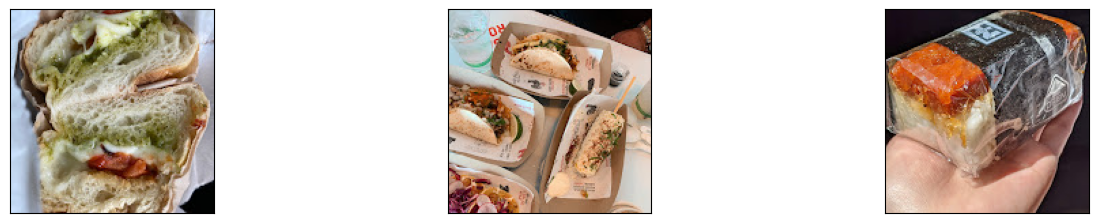

In [ ]:
display_image_uris(retrieved_images)

## Build score dictionary for top retrieved restraunts

In [ ]:
restraunt_score = defaultdict(lambda: defaultdict(float))
# restraunt_image_score = defaultdict(lambda: 0.0)
for res_node in response:
    id = res_node.node.metadata["gmap_id"]
    if isinstance(res_node.node, ImageNode):
        # retrieved_images.append(res_node.node.image_path)
        restraunt_score[id]["image"] = max(
            res_node.score, restraunt_score[id]["image"]
        )
        restraunt_score[id]["image_path"] = res_node.node.image_path
    else:
        restraunt_score[id]["text"] = max(
            res_node.score, restraunt_score[id]["text"]
        )
        restraunt_score[id]["review"] = res_node.node.text
        # restraunt_text_score[id] = max(res_node.score, restraunt_text_score[id])
    restraunt_score[id]["rating"] = res_node.node.metadata["rating"]


for id in restraunt_score:
    print(
        id,
        restraunt_score[id]["image"],
        restraunt_score[id]["text"],
        restraunt_score[id]["rating"],
    )

0x7c008bdd7ebfe161:0xe04d5de101a266ae 0.0 0.8250716417611288 5
0x7c007278edb2a865:0x4ed1c3d61fda94aa 0.2903903344561772 0.8208614473896383 5
0x7954d2c20cb7ec5f:0x125d0dfdf7fd7b30 0.23697567207474157 0.8159435415926457 4
0x7954d376a8b12db3:0xa51dd57e1cc14ca9 0.0 0.8003223137531607 5
0x7eaad4c65352eddf:0xe88cc994f4822e63 0.0 0.796768063799382 5
0x7c06e132e123e925:0xbc09611c3bf0b3c3 0.0 0.7937583357297203 5
0x7954d03f1651832b:0xfc465817c5bb7bc7 0.0 0.7929208865356309 4
0x7954d332107caa35:0xc630efdfc08cc59 0.0 0.7918249440511616 3
0x7c00137bbb534d6f:0x46b43968fa377bc0 0.25383195555600374 0.7886452234185228 1
0x7954ad0f41bb63df:0x9a0a5f3ccab74bc6 0.0 0.7850321597602321 5
0x7c06e1349cf54817:0xd5e5a2e4ebcb4083 0.0 0.7827427950058526 3
0x7c004f5796e4e481:0xe236bd304df7a776 0.0 0.780652453689182 5
0x7954d37344f52053:0x383da74bce73cc2d 0.2563930191888528 0.0 5
0x7c0051c18322c221:0x356fa0faa6488d2b 0.2506780904902613 0.0 5
0x7c0065a14a3b6643:0x4cfafc2002880a22 0.24450095182194198 0.0 5
0x79540efb

## Simple Fusion/Reranking Store based on image retrieval and text retrieval scores

In [ ]:
def simple_fusion_score(a, b):
    return pow(1.0 + a, 1.0 + b)


max_score = 0.0
max_id = ""
for id in restraunt_score:
    final_score = simple_fusion_score(
        restraunt_score[id]["text"], restraunt_score[id]["image"]
    )
    restraunt_score[id]["final_score"] = final_score
    if final_score > max_score:
        max_score = final_score
        max_id = id
print(
    max_id,
    max_score,
    restraunt_score[max_id]["rating"],
    restraunt_score[max_id]["image_path"],
    restraunt_score[max_id]["review"],
)

0x7c007278edb2a865:0x4ed1c3d61fda94aa 2.1669994299938162 5 google_review_data/19.jpg Great place for a quick bite. Good food, friendly staff and great smoothies.


## Get the highest scoring score, let GPT4V give a final relevance score for this search query to store review/image pair
The relevance score can be used to train downstream relevance ranking model

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader
from llama_index.schema import ImageDocument

# put your local directore here
image_documents = [
    ImageDocument(image_path=restraunt_score[max_id]["image_path"])
]
response = restraunt_score[max_id]["review"]
# for res_img in retrieved_images[1:]:
#     image_documents.append(ImageDocument(image_path=res_img))


openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)
response = openai_mm_llm.complete(
    prompt="""Assume you are a search relevance labeler, given the search query {search_query}, the input image, 
    and the response "{response}", 
    how relevant is the response to the search query and the input image. give a score between 0 and 1.""".format(
        search_query=search_query, response=response
    ),
    image_documents=image_documents,
)

print(response)

The image shows what appears to be a cafe or sandwich shop, with a menu board in the background and a display case that might contain food items. Given the search query "sandwich" and the input image, the response "Great place for a quick bite. Good food, friendly staff and great smoothies." is quite relevant, as it provides a positive review of a food establishment, which is consistent with what someone might be looking for when they search for "sandwich."

Assuming the place in the image serves sandwiches, which is a fair assumption given the context, the response suggests that one can expect to find good food, which could include sandwiches, and additional amenities like friendly staff and smoothies, adding to the relevance of this establishment as a place to get a sandwich.

Based on this, I would give a relevance score of 0.8 - 0.9, reflecting the high relevance but not absolute certainty that sandwiches are served or the focus of the establishment.
